## Problem Set #[2] - Integration
MACS 30150, Dr. Evans    
Linghui Wu

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.stats import norm, lognorm

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

### Exercise 2.1.

In [2]:
def integration(g, a, b, N, method):
    if method not in {"midpoint", "trapezoid", "Simpsons"}:
        raise ValueError
    else:
        if method == "midpoint":
            itgr = 0
            for i in range(1, N):
                itgr += g(a + (2 * i + 1) * (b - a) / (2 * N))
            return (b - a) / N * itgr
        elif method == "trapezoid":
            itgr = g(a) + g(b)
            for i in range(1, N):
                itgr += 2 * g(a + i * (b - a) / N)
            return (b - a) / (2 * N) * itgr
        elif method == "Simpsons":
            itgr = g(a) + g(b)
            for i in range(1, N):
                itgr += 2 * g(a + 2 * i * (b - a) / (2 * N))
            for i in range(N + 1):
                itgr += 4 * g(a + (2 * i - 1) * (b - a) / (2 * N))
            return (b - a) / (6 * N) * itgr

In [3]:
g = lambda x: 0.1 * x ** 4 - 1.5 * x ** 3 + 0.53 * x * x + 2 * x + 1
N = 40
mid = integration(g, -10, 10, N, "midpoint")
tra = integration(g, -10, 10, N, "trapezoid")
sim = integration(g, -10, 10, N, "Simpsons")
tru_val = 4373 + 1 / 3

methods = {"Midpoint", "Trapezoid", "Simpsons"}
approxs = [mid, tra, sim]
for m, a in zip(methods, approxs):
    print(m, "'s approximation value:\t\t", a)
    print("Difference between ", m, "and  true value: \t", abs(a - tru_val))

Midpoint 's approximation value:		 3201.8527734374998
Difference between  Midpoint and  true value: 	 1171.4805598958333
Simpsons 's approximation value:		 4390.437500000001
Difference between  Simpsons and  true value: 	 17.10416666666788
Trapezoid 's approximation value:		 5291.778359374999
Difference between  Trapezoid and  true value: 	 918.4450260416661


### Exercise 2.2.

In [4]:
def NC_discrete(mean, sigma, N, k):
    z = np.linspace(mean - k * sigma, mean + k * sigma, N)
    w = np.zeros(N)
    w[0] = norm.cdf((z[0] + z[1]) / 2, loc=mean, scale=sigma) 
    w[-1] = 1 - norm.cdf((z[-1] + z[-2]) / 2, loc=mean, scale=sigma)
    for i in range(1, N-1):
        z_min = (z[i-1] + z[i]) / 2
        z_max = (z[i] + z[i+1]) / 2
        norm_pdf = lambda x: norm.pdf(x, loc=mean, scale=sigma)
        w[i] = quad(norm_pdf, z_min, z_max)[0]
    return z, w

In [5]:
z, w = NC_discrete(0, 1, 11, 5)
norm_df = pd.DataFrame({"z":z, "weight": w})
norm_df.index += 1
norm_df

,z,weight
1,-5.0,0.000003
2,-4.0,0.000229
3,-3.0,0.005977
4,-2.0,0.060598
5,-1.0,0.241730
6,0.0,0.382925
7,1.0,0.241730
8,2.0,0.060598
9,3.0,0.005977
10,4.0,0.000229


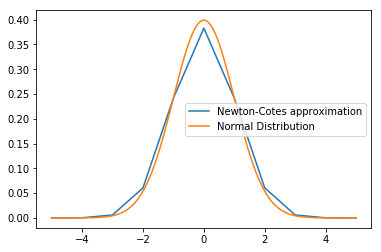

In [6]:
plt.plot(z, w, label="Newton-Cotes approximation")

x = np.linspace(-5, 5, 1000)
plt.plot(x, mlab.normpdf(x, 0, 1), label="Normal Distribution")

plt.legend()
plt.show()

**It can be inferred from the graph that the Newton-Cotes discrete method is a good approximation of the normal distribution.**

### Exercise 2.3.

In [7]:
def NC_logdiscrete(mean, sigma, N, k):
    z, w = NC_discrete(mean, sigma, N, k)
    A = np.exp(z)
    return A, w

In [8]:
A, w = NC_logdiscrete(0, 1, 11, 3)
lognorm_df = pd.DataFrame({"A": A, "weight": w})
lognorm_df.index += 1
lognorm_df

,A,weight
1,0.049787,0.003467
2,0.090718,0.014397
3,0.165299,0.048943
4,0.301194,0.117253
5,0.548812,0.198028
6,1.000000,0.235823
7,1.822119,0.198028
8,3.320117,0.117253
9,6.049647,0.048943
10,11.023176,0.014397


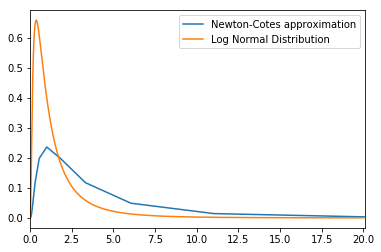

In [9]:
plt.plot(A, w, label="Newton-Cotes approximation")

x = np.linspace(0, 20, 1000)
plt.plot(x, lognorm.pdf(x, 1, 0, 1), label="Log Normal Distribution")
 
plt.legend(loc="upper right")
plt.margins(x=0)
plt.show()

**The Newton-Cotes discrete approximation graph resembles the log-normal distribution.**

### Exercise 2.4.

In [10]:
mean = 10.5
sigma = 0.8

w, z = NC_logdiscrete(mean, sigma, 1000, 5)
approx_income = sum(w * z)
exact_income = np.exp(mean + sigma ** 2 / 2)
print("My approximation: ", approx_income)
print("The exact expected value: ", exact_income)
print("The difference: ", abs(approx_income - exact_income))

My approximation:  50011.12159719643
The exact expected value:  50011.087008521754
The difference:  0.034588674672704656


### Exercise 3.1.

In [11]:
from scipy import optimize

def Gaus(g, a, b, N):
    init_weight = [1 / N for i in range(N)]
    init_x = [a + i * (b - a) / (N - 1) for i in range(N)]
    init = init_weight + init_x

    def funcs(x):
        result = []
        for i in range(2 * N):
            weight = x[:N]
            node = x[N:]
            equal_right = sum(weight[k] * (node[k] ** i) for k in range(N))
            equal_left = (b ** (i + 1) - a ** (i + 1)) / (i + 1)
            result.append(equal_left - equal_right)
        return tuple(val for val in result)

    optimal = [val for val in optimize.root(funcs, init)["x"]]
    weights = optimal[:N]
    nodes = optimal[N:]
    rv = 0
    for i in range(N):
        rv += weights[i] * g(nodes[i])
    return rv

In [12]:
g = lambda x: 0.1 * x ** 4 - 1.5 * x ** 3 + 0.53 * x * x + 2 * x + 1
gaus1 = Gaus(g, -10, 10, 3)

print("Gaussian Quadrature method approximation value:", gaus1)
print("Difference between Gaussian Quadrature method and the true value:", abs(gaus1 - tru_val))

Gaussian Quadrature method approximation value: 4373.333333189601
Difference between Gaussian Quadrature method and the true value: 1.4373199519468471e-07


**The Gaussian method provides a approximate integral to the 7th decimal of the true value.**

**Note that the weights and nodes calculated by the `scipy.optimize.root` method have some fractional error compared to a more accurate N=3 weights and nodes(https://pomax.github.io/bezierinfo/legendre-gauss.html#n3).**

In [13]:
import math
a, b = -10, 10
(w1, w2, w3, x1, x2, x3) = (8/9, 5/9, 5/9, 0, -math.sqrt(0.6), math.sqrt(0.6))
s, e = (b - a) / 2, (b + a) / 2
gaus2 = s * (w1 * g(s * x1 + e) + w2 * g(s * x2 + e) + w3 * g(s * x3 + e))

print("More accurate Gaussian Quadrature method approximation value:", gaus2)
print("Difference between Gaussian Quadrature method and the true value:", abs(gaus2 - tru_val))

More accurate Gaussian Quadrature method approximation value: 4373.333333333334
Difference between Gaussian Quadrature method and the true value: 9.094947017729282e-13


### Exercise 3.2.

In [14]:
from scipy.integrate import quad
g = lambda x: 0.1*x** 4 - 1.5*x**3 + 0.53*x*x + 2*x + 1
gaus3 = quad(g, -10, 10)[0]

print("Scipy Gaussian Quadrature method approximation value:", gaus3)
print("Difference between Gaussian Quadrature method and the true value:", abs(gaus3 - tru_val))

Scipy Gaussian Quadrature method approximation value: 4373.333333333334
Difference between Gaussian Quadrature method and the true value: 9.094947017729282e-13


### Exercise 4.1.

In [15]:
np.random.seed(seed = 25)
g = lambda x, y: x**2 + y**2 <= 1

def MonteCarlo(g, omega, N):
    rand_x = np.random.uniform(omega[0][0], omega[0][1], N)
    rand_y = np.random.uniform(omega[1][0], omega[1][1], N)
    total = np.sum(g(rand_x, rand_y))
    
    area = abs(omega[0][0]- omega[0][1]) * abs(omega[1][0]- omega[1][1])
    return area * total / N

In [16]:
N = 1
omega = np.array([[-1, 1,], [-1, 1]])
while round(MonteCarlo(g, omega, N), 4) != 3.1415:
    N += 1
print("The smallest number of random draws N is ", N)

The smallest number of random draws N is  615


### Exercise 4.2.

In [17]:
import numpy as np

def isPrime(n):
    '''
    --------------------------------------------------------------------
    This function returns a boolean indicating whether an integer n is a
    prime number
    --------------------------------------------------------------------
    INPUTS:
    n = scalar, any scalar value

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    i = integer in [2, sqrt(n)]

    FILES CREATED BY THIS FUNCTION: None

    RETURN: boolean
    --------------------------------------------------------------------
    '''
    for i in range(2, int(np.sqrt(n) + 1)):
        if n % i == 0:
            return False

    return True

In [18]:
def primes_ascend(N, min_val=2):
    '''
    --------------------------------------------------------------------
    This function generates an ordered sequence of N consecutive prime
    numbers, the smallest of which is greater than or equal to 1 using
    the Sieve of Eratosthenes algorithm.
    (https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes)
    --------------------------------------------------------------------
    INPUTS:
    N       = integer, number of elements in sequence of consecutive
              prime numbers
    min_val = scalar >= 2, the smallest prime number in the consecutive
              sequence must be greater-than-or-equal-to this value

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        isPrime()

    OBJECTS CREATED WITHIN FUNCTION:
    primes_vec     = (N,) vector, consecutive prime numbers greater than
                     min_val
    MinIsEven      = boolean, =True if min_val is even, =False otherwise
    MinIsGrtrThn2  = boolean, =True if min_val is
                     greater-than-or-equal-to 2, =False otherwise
    curr_prime_ind = integer >= 0, running count of prime numbers found

    FILES CREATED BY THIS FUNCTION: None

    RETURN: primes_vec
    --------------------------------------------------------------------
    '''
    primes_vec = np.zeros(N, dtype=int)
    MinIsEven = 1 - min_val % 2
    MinIsGrtrThn2 = min_val > 2
    curr_prime_ind = 0
    if not MinIsGrtrThn2:
        i = 2
        curr_prime_ind += 1
        primes_vec[0] = i
    i = min(3, min_val + (MinIsEven * 1))
    while curr_prime_ind < N:
        if isPrime(i):
            curr_prime_ind += 1
            primes_vec[curr_prime_ind - 1] = i
        i += 2

    return primes_vec

In [19]:
def equiseq(n, d, seq):
    prime_seq = primes_ascend(d, min_val = 2)
    if seq == "Weyl":
        weyl_1 = np.sqrt(prime_seq) * n
        weyl = weyl_1 - np.floor(weyl_1)
        return weyl
    elif seq == "Haber":
        haber_1 = np.sqrt(prime_seq) * n * (n+1) / 2
        haber = haber_1 - np.floor(haber_1)
        return haber
    elif seq == "Niederreiter":
        e = [i / (n+1) for i in range(1, d+1)]
        niederreiter_1 = n * np.power(2, e)
        niederreiter = niederreiter_1 - np.floor(niederreiter_1)
        return niederreiter
    elif seq == "Baker":
        r = [1 / i for i in range(1, d+1)]
        baker_1 = n * np.exp(r)
        baker = baker_1 - np.floor(baker_1)
        return baker

In [20]:
for i in ["Weyl", "Haber", "Niederreiter", "Baker"]:
    print(i, ": ", equiseq(20, 4, i))

Weyl :  [0.28427125 0.64101615 0.72135955 0.91502622]
Haber :  [0.9848481  0.73066959 0.57427527 0.60777532]
Niederreiter :  [0.67115566 0.36483382 0.08179027 0.8228062 ]
Baker :  [0.36563657 0.97442541 0.9122485  0.68050833]


### Exercise 4.3.

In [21]:
np.random.seed(seed=25)
g = lambda x, y: x**2 + y**2 <= 1

def QuasiMonteCarlo(g, omega, N, seq):
    var = []
    for i in range(N):
        var.append((2 * equiseq(i, 2, seq)[0] - 1, 2 * equiseq(i, 2, seq)[1] - 1))
    total = 0
    for i in range(N):
        total += g(var[i][0], var[i][1])
    area = abs(omega[0][0]- omega[0][1]) * abs(omega[1][0]- omega[1][1])
    return area * total / N

In [22]:
print("The approximation of pi")
omega = np.array([[-1, 1,], [-1, 1]])
N = 100
for i in ["Weyl", "Haber", "Niederreiter", "Baker"]:
    print(i, ": ", QuasiMonteCarlo(g, omega, N, i), sep="")

The approximation of pi
Weyl: 3.08
Haber: 3.36
Niederreiter: 3.92
Baker: 3.08


In [23]:
def min_N(seq):
    N = 1
    while round(QuasiMonteCarlo(g, omega, N, seq), 4) != 3.1415:
        N += 1
        if N >= 5000:
            print(i, "'s smallest number of random draws exceeds 2500'", sep="")
            break
    print("The smallest number of random draws N with ", i, " is ", N, sep="")

In [24]:
for i in ["Weyl", "Haber", "Niederreiter", "Baker"]:
    min_N(i)

The smallest number of random draws N with Weyl is 1230
The smallest number of random draws N with Haber is 2064
Niederreiter's smallest number of random draws exceeds 2500'
The smallest number of random draws N with Niederreiter is 5000
The smallest number of random draws N with Baker is 205


**The results above show that `Baker` is the fastest method converging to 3.1415 and Niederreiter is the slowest one.**

**It is rather hard to find a finite number for Niederreiter to converge to 3.1415.**